# Workflow to fully automate the substituent parameter calculation of the authors

The substituent parameter protocol developed by the authors is able to be fully automated in `aiida-aimall` through use of the [SubstituentParameterWorkchain](../reference/api/auto/aiida_aimall/workchains/index.rst#aiida_aimall.workchains.SubstituentParameterWorkChain). This workchain undertakes the following steps

1. Gaussian optimization of the input structure
2. performs AIM on the output wfx file
3. Uses that AIM calculation to reorient the molecule
4. Runs a Gaussian singlepoint on the resulting structure
5. Runs AIM on the resulting file using the [AimqbGroupParser](../reference/api/auto/aiida_aimall/parsers/index.rst#aiida_aimall.parsers.AimqbGroupParser), with the group being set to all atoms except for atom 2 (typically a substrate hydrogen)

Inputs are similar to other parts of the package that have already been used. You should provide as inputs to the builder:

1. structure (`orm.StructureData`)
2. gauss_code - setup code for `Gaussian` Software
3. aim_code - setup code for `AIMQB` software
4. aim_params ([AimqbParameters](../reference/api/auto/aiida_aimall/data/index.rst#aiida_aimall.data.AimqbParameters))
5. g16_opt_params (`orm.Dict`) - parameters for the Gaussian optimization calculation
6. g16_sp_params (`orm.Dict`) - parameters for the Gaussian singlepoint calculation. **Note that the route parameters should include "nosymmetry":None in the dictionary as a key/value pair
7. wfx_filename (`orm.Str`) -  if the wfx filename in the Gaussian parameters inputs is different than "output.wfx", provide the actual wfx filename here.

In [3]:
from aiida.plugins import WorkflowFactory, DataFactory
from aiida.orm import Dict, StructureData, load_code
from aiida.engine import submit
from aiida import load_profile
import io
import ase.io

load_profile()

SubstituentParameterWorkchain = WorkflowFactory('aimall.subparam')
AimqbParameters = DataFactory('aimall.aimqb')
aim_input = AimqbParameters({'nproc':2,'naat':2,'atlaprhocps':True})
gaussian_opt = Dict(
            {
                "link0_parameters": {
                    "%chk": "aiida.chk",
                    "%mem": "3200MB",  # Currently set to use 8000 MB in .sh files
                    "%nprocshared": 4,
                },
                "functional": "wb97xd",
                "basis_set": "aug-cc-pvtz",
                "charge": 0,
                "multiplicity": 1,
                "route_parameters": {"opt": None, "Output": "WFX"},
                "input_parameters": {"output.wfx": None},
            }
)
gaussian_sp = Dict(
            {
                "link0_parameters": {
                    "%chk": "aiida.chk",
                    "%mem": "3200MB",  # Currently set to use 8000 MB in .sh files
                    "%nprocshared": 4,
                },
                "functional": "wb97xd",
                "basis_set": "aug-cc-pvtz",
                "charge": 0,
                "multiplicity": 1,
                "route_parameters": {"nosymmetry": None, "Output": "WFX"},
                "input_parameters": {"output.wfx": None},
            }
)
f = io.StringIO(
                "5\n\n C -0.1 2.0 -0.02\nH 0.3 1.0 -0.02\nH 0.3 2.5 0.8\nH 0.3 2.5 -0.9\nH -1.2 2.0 -0.02"
            )
struct_data = StructureData(ase=ase.io.read(f, format="xyz"))
f.close()
builder = SubstituentParameterWorkchain.get_builder()
builder.g16_code = load_code('gaussian@localhost')
builder.aim_code = load_code('aimall@localhost')
builder.g16_opt_params = gaussian_opt
builder.g16_sp_params = gaussian_sp
builder.structure = struct_data
builder.aim_params = aim_input
submit(builder)



<WorkChainNode: uuid: 59867ae6-1165-40eb-a4a2-34939b3957d8 (pk: 114502) (aiida.workflows:aimall.subparam)>

## Outputs

The provenace graph generates shows a full history of the calculation, and its final outputs are the output_parameters of the final AIMQB calculation.

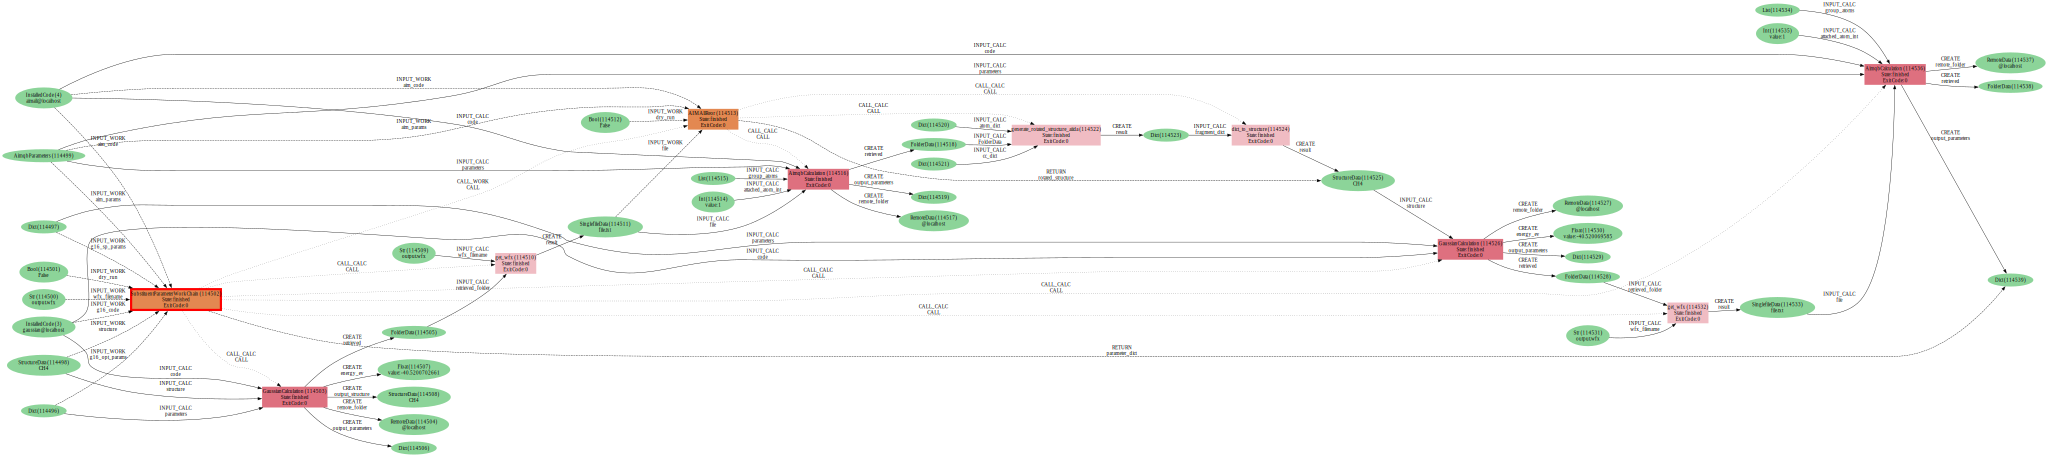

In [4]:
from aiida.tools.visualization import Graph
graph = Graph(graph_attr={"size": "6,6!", "rankdir": "LR"})
graph = Graph(graph_attr={"rankdir": "LR"})
graph.recurse_descendants(
    114502,
    origin_style=None,
    include_process_inputs=True,
    annotate_links="both"
)
graph.graphviz